In [25]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
from tensorflow.keras.optimizers import RMSprop


In [26]:
import fluidsynth

In [27]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [28]:
filenames = glob.glob(str("MIDI/pop/**/*.mid"))
# filenames = glob.glob(str("/home/jayden/projects/project_lyrics/MIDI/pop/**/*.mid"))
print('Number of files: ', len(filenames))
sample_file = filenames[1]
print(sample_file)

Number of files:  2969
MIDI/pop/Marcels/IWantYouToLoveMe.mid


In [29]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [30]:
#오디오를 30초간 들을수 있게 시험.
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [31]:
display_audio(pm)

In [32]:
#악기 종류 찾아내기
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for num in range(len(pm.instruments)):
    print('All instruments:' , pretty_midi.program_to_instrument_name(pm.instruments[num].program))

Number of instruments: 12
Instrument name: Acoustic Grand Piano
All instruments: Acoustic Grand Piano
All instruments: Electric Grand Piano
All instruments: Acoustic Guitar (steel)
All instruments: Acoustic Guitar (steel)
All instruments: Shakuhachi
All instruments: Rock Organ
All instruments: Electric Bass (finger)
All instruments: Electric Guitar (jazz)
All instruments: Choir Aahs
All instruments: String Ensemble 1
All instruments: Acoustic Grand Piano
All instruments: Electric Guitar (clean)


In [33]:
#하나의 악기에서 음악 노트 추출
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

print(len(instrument.notes))

0: pitch=42, note_name=F#2, duration=0.0130
1: pitch=42, note_name=F#2, duration=0.0130
2: pitch=42, note_name=F#2, duration=0.0130
3: pitch=42, note_name=F#2, duration=0.0130
4: pitch=44, note_name=G#2, duration=0.0130
5: pitch=44, note_name=G#2, duration=0.0130
6: pitch=44, note_name=G#2, duration=0.0130
7: pitch=44, note_name=G#2, duration=0.0130
8: pitch=44, note_name=G#2, duration=0.0130
9: pitch=44, note_name=G#2, duration=0.0130
1025


In [34]:
# training model requires 3 variables (pitch, step, duration)
# pitch : perceptual quality of the sound as a midi note
# step : time elapsed from previous note or start of the track
# duration : duration of the current note
# 미디 파일에서 음표 추출하는 부분.

# return pd.DataFrame
def midi_to_notes(midi_file: str):
  try:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0] #val of single instrument
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  except OSError as e:
    print(f"Error processing MIDI file '{midi_file}': {e}")
  except ValueError as ve:
    print(f"ValueError occurred while processing file {midi_file}: {ve}")
  except Exception as e:
    print(f"Error occurred while processing file {midi_file}: {e}")

  

In [35]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head(20)

,pitch,start,end,step,duration
0,42,1.123377,1.136364,0.000000,0.012987
1,42,1.902598,1.915585,0.779221,0.012987
2,42,2.681819,2.694806,0.779221,0.012987
3,42,3.461040,3.474027,0.779221,0.012987
4,44,5.019482,5.032469,1.558442,0.012987
5,44,6.577924,6.590911,1.558442,0.012987
6,44,8.136366,8.149353,1.558442,0.012987
7,44,9.694808,9.707795,1.558442,0.012987
8,44,11.253250,11.266237,1.558442,0.012987
9,44,12.811692,12.824679,1.558442,0.012987


In [36]:
#음표로 바꿔서 해석해보기.
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F#2', 'F#2', 'F#2', 'F#2', 'G#2', 'G#2', 'G#2', 'G#2', 'G#2',
       'G#2'], dtype='<U3')

In [37]:
# 악곡은 노트의 연속성이니 시각화 해보기. 첫번쨰 instrument 가 피아노니까 트랙 길이에 음표, 피치, 시작 & 끝을 플롯해보기.
# count 는 input 에 있거나 없거나 상관없음. 
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

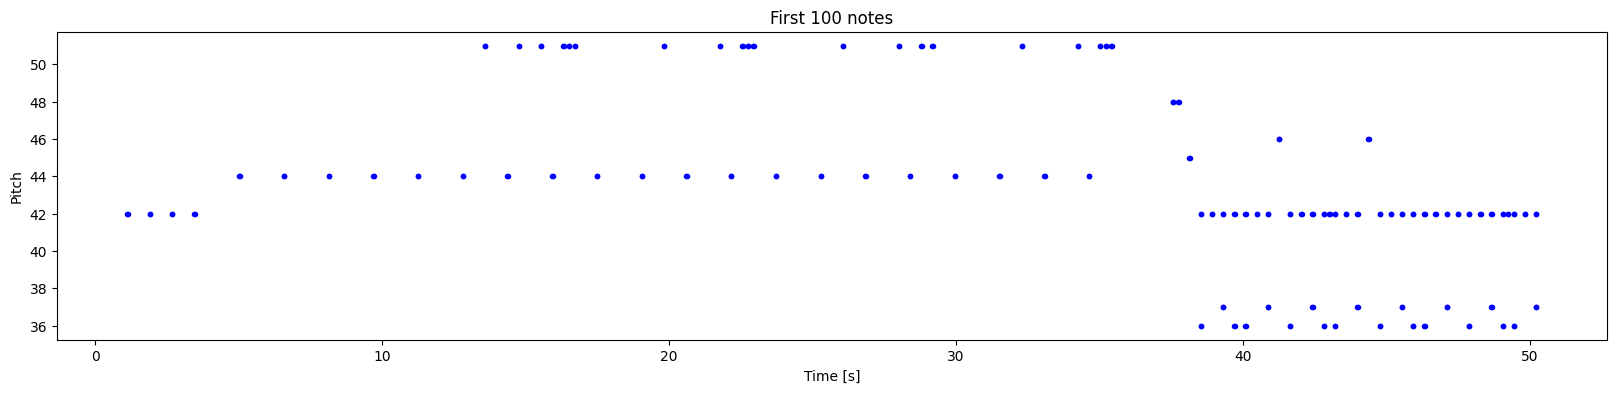

In [38]:
plot_piano_roll(raw_notes, count=100)

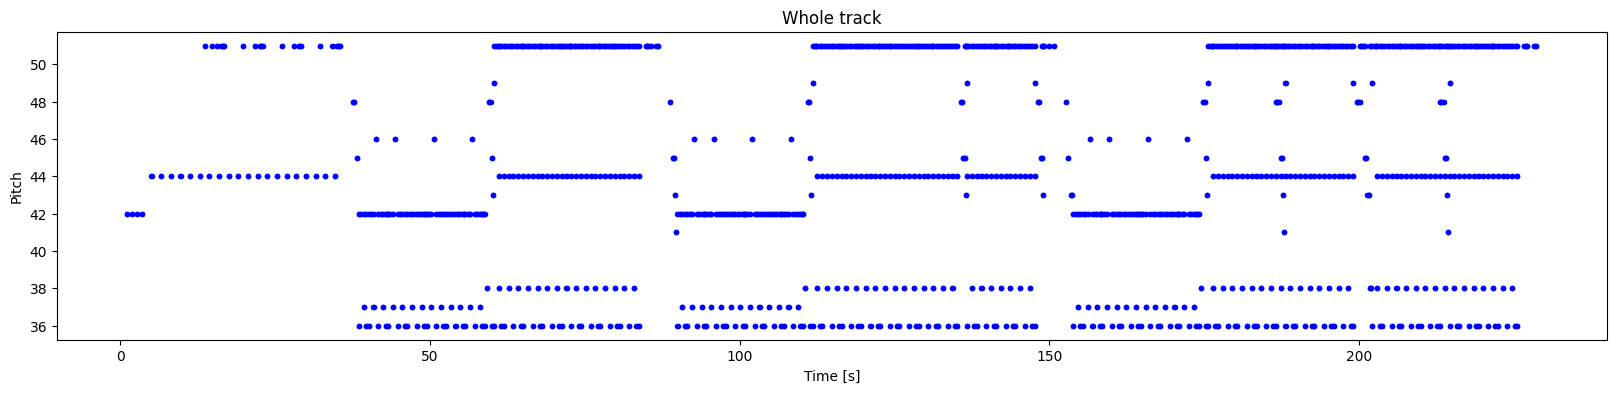

In [39]:
# 전체 트랙의 음악 노트 표현.
plot_piano_roll(raw_notes)

In [40]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

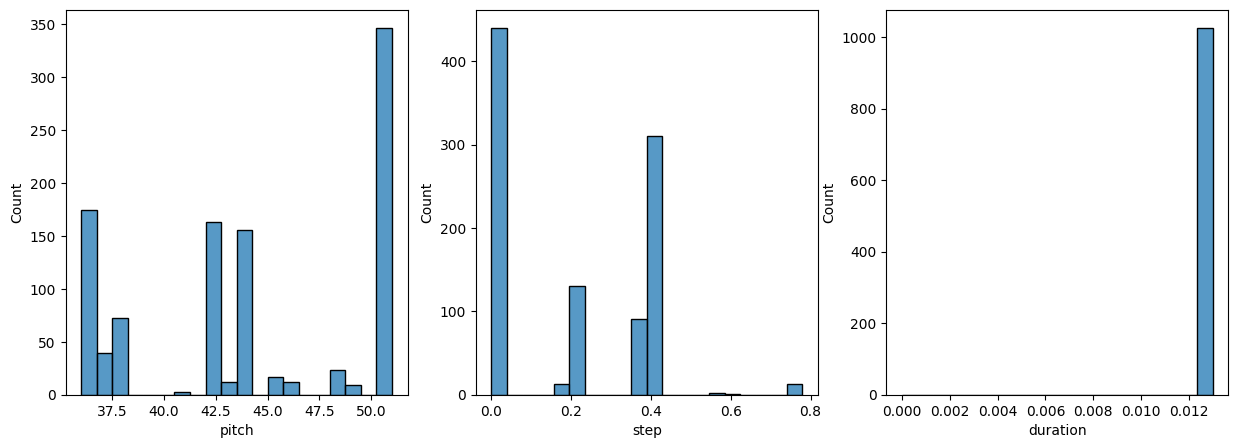

In [41]:
plot_distributions(raw_notes)

## MIDI 파일 생성

In [42]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name)) #피아노를 넣으면 피아노가 있는 경우에 그것의 맞는 숫자를 리턴

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [43]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [44]:
display_audio(example_pm)

## 훈련 데이터 세트 생성

In [45]:
# MIDI 파일에서 노트 추출하기. 적은수로 실험
num_files = 200 #일단 작은 숫자로 트레이닝.
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing MIDI file 'MIDI/pop/5th Dimension/OneLessBellToAnswere.mid': no MTrk header at start of track
Error processing MIDI file 'MIDI/pop/Bee Gee/GreaseMegamix .mid': data byte must be in range 0..127
ValueError occurred while processing file MIDI/pop/Newsboys/PartyInTheUSA.mid: data byte must be in range 0..127
Error processing MIDI file 'MIDI/pop/Gary Wright/DarnThatDream.mid': data byte must be in range 0..127
Error processing MIDI file 'MIDI/pop/Brandy/CatLikeThief.mid': MThd not found. Probably not a MIDI file
Error occurred while processing file MIDI/pop/Mungo Jerry/Metoo.mid: list index out of range
ValueError occurred while processing file MIDI/pop/Ricky Martin/SolsburyHill.mid: data byte must be in range 0..127
Error processing MIDI file 'MIDI/pop/Haddaway/AnythingForYou.mid': MThd not found. Probably not a MIDI file
Error processing MIDI file 'MIDI/pop/Haddaway/BreakingUpIsHardToDo.mid': MThd not found. Probably not a MIDI file
Error processing MIDI file 'MIDI/pop/H

In [46]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 814511


In [47]:
#create tensor dataset
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [48]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2024-04-08 15:37:32.181623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:37:32.260119: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:37:32.260153: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:37:32.262110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 15:37:32.262136: I external/local_xla/xla/stream_executor

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [49]:
#노트 시퀀스로 다음 음표 예측 훈련.
#기존에 있는 노트들을 시퀀스로 묶고 그것으로 다음 시퀀스 예측.
#시퀀스가 길수록 한번에 묶여있는 노트의 숫자 증가.

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [50]:
#시퀀스 길이 조정. 
seq_length = 30 #변환 가능.
vocab_size = 128 #pretty_midi 의 최대 피치 수.
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(15, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [51]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (15, 3)
sequence elements (first 10): tf.Tensor(
[[0.546875   0.         0.29220787]
 [0.546875   0.3896105  0.27272735]
 [0.546875   0.3896105  0.25974033]
 [0.546875   0.3896105  0.24025981]
 [0.5625     0.3896105  0.22727279]
 [0.578125   0.3896105  0.14285718]
 [0.5078125  0.19480525 3.66883221]
 [0.5078125  4.675326   0.0779221 ]
 [0.546875   0.19480525 0.27272735]
 [0.546875   0.3896105  0.24025981]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.19480524999999815>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.09740262500000085>}


In [52]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

2024-04-08 15:37:33.380658: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-04-08 15:37:33.380681: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-04-08 15:37:33.380713: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:37:33.380725: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:37:33.380837: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:37:33.380853: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] 

In [53]:
train_ds.element_spec

(TensorSpec(shape=(64, 15, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

모델 생성 및 학습

In [54]:
# 음수 말고 양수쪽으로 움직이게 weight 를 더 주기.

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [55]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

2024-04-08 15:37:33.799783: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


In [56]:
losses = model.evaluate(train_ds, return_dict=True)
losses

2024-04-08 15:37:44.314870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 148520 of 814496
2024-04-08 15:37:54.314874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 295229 of 814496
2024-04-08 15:38:04.314872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 436366 of 814496
2024-04-08 15:38:14.314934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:38: Filling up shuffle buffer (this may take a while): 580911 of 814496
2024-04-08 15:38:30.754588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2024-04-08 15:38:30.801481: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-08 15:38:30.852178: W tensorflow/compiler/mlir/tools/kernel_gen/tr

     20/Unknown - 57s 6ms/step - loss: 6.2376 - duration_loss: 0.6244 - pitch_loss: 4.8568 - step_loss: 0.7563

2024-04-08 15:38:31.041401: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:38:31.041442: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:38:31.043067: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:38:31.043179: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:38:31.043523: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08

12726/12726 [==============================] - 96s 3ms/step - loss: 7.1175 - duration_loss: 0.9935 - pitch_loss: 4.8562 - step_loss: 1.2678


2024-04-08 15:39:09.744010: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15255095049418993481
2024-04-08 15:39:09.744066: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6635600893774875292
2024-04-08 15:39:09.744078: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12291672232667386638
2024-04-08 15:39:09.744109: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16521134591343502356


{'loss': 7.117475509643555,
 'duration_loss': 0.9935420155525208,
 'pitch_loss': 4.8561601638793945,
 'step_loss': 1.2677581310272217}

In [57]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [58]:
model.evaluate(train_ds, return_dict=True)

12726/12726 [==============================] - 40s 3ms/step - loss: 2.5041 - duration_loss: 0.9935 - pitch_loss: 4.8562 - step_loss: 1.2678


2024-04-08 15:39:50.194716: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15255095049418993481
2024-04-08 15:39:50.194748: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6635600893774875292
2024-04-08 15:39:50.194751: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12291672232667386638
2024-04-08 15:39:50.194764: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16521134591343502356


{'loss': 2.5041091442108154,
 'duration_loss': 0.9935420155525208,
 'pitch_loss': 4.8561601638793945,
 'step_loss': 1.2677581310272217}

In [59]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [60]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50


2024-04-08 15:39:51.163835: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f90611b6b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 15:39:51.163865: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti SUPER, Compute Capability 8.9
2024-04-08 15:39:51.167472: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-08 15:39:51.171056: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:39:51.171419: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-04-08 15:39:51.191621: W external/local_xla/xla/service/gpu

12726/12726 [==============================] - 74s 6ms/step - loss: 1.6764 - duration_loss: 0.3739 - pitch_loss: 3.3275 - step_loss: 1.1362
Epoch 2/50
   28/12726 [..............................] - ETA: 1:14 - loss: 0.6956 - duration_loss: 0.0544 - pitch_loss: 3.1120 - step_loss: 0.4856

2024-04-08 15:41:04.399950: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15255095049418993481
2024-04-08 15:41:04.399992: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6635600893774875292


12726/12726 [==============================] - 75s 6ms/step - loss: 1.6236 - duration_loss: 0.3512 - pitch_loss: 3.0673 - step_loss: 1.1190
Epoch 3/50
12726/12726 [==============================] - 73s 6ms/step - loss: 1.5886 - duration_loss: 0.3339 - pitch_loss: 2.8881 - step_loss: 1.1103
Epoch 4/50
12726/12726 [==============================] - 71s 6ms/step - loss: 1.5546 - duration_loss: 0.3069 - pitch_loss: 2.8005 - step_loss: 1.1077
Epoch 5/50
12726/12726 [==============================] - 71s 6ms/step - loss: 1.5226 - duration_loss: 0.2787 - pitch_loss: 2.7598 - step_loss: 1.1060
Epoch 6/50
12726/12726 [==============================] - 72s 6ms/step - loss: 1.5033 - duration_loss: 0.2647 - pitch_loss: 2.7276 - step_loss: 1.1022
Epoch 7/50
12726/12726 [==============================] - 74s 6ms/step - loss: 1.4978 - duration_loss: 0.2603 - pitch_loss: 2.7127 - step_loss: 1.1019
Epoch 8/50
12726/12726 [==============================] - 74s 6ms/step - loss: 1.5161 - duration_loss: 0.

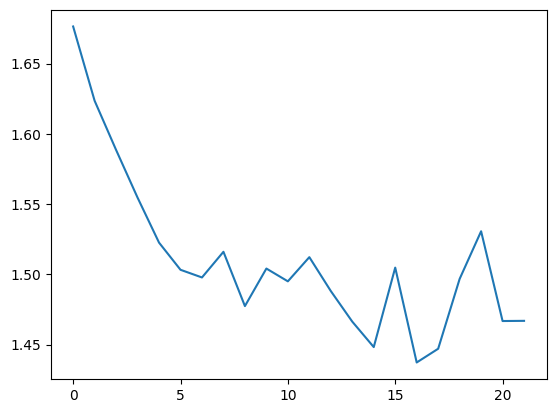

In [61]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

Generating the notes

In [62]:
# 예측을 하려면 노트의 시퀀스를 넣어야함.
# 노트의 시퀀스를 만들어서 넣기.
# 노트 피치는 소프트맥스 함수로 나눠진거에서 샘플로 여러개를 가지고 오고 제일 높은 확률만 가져오지 않음

def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0 #온도가 노트들 랜덤생성하게 하는거 도와주는 펑션

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

실제로 만들어보기

In [74]:
raw_notes = midi_to_notes(filenames[2])

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [77]:
#온도, 시작 시퀀스 가지고 바꿔보기.
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 12ms/step


In [64]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,47,0.741423,0.014447,0.741423,0.755870
1,79,0.244743,0.114271,0.986166,1.100437
2,79,0.239135,0.155583,1.225301,1.380884
3,79,0.223521,0.161473,1.448822,1.610295
4,85,0.238296,0.169700,1.687117,1.856817
5,94,0.258098,0.136931,1.945215,2.082146
6,94,0.282654,0.081816,2.227869,2.309685
7,94,0.286473,0.029034,2.514342,2.543376
8,85,0.281784,0.000000,2.796126,2.796126
9,94,0.308617,0.000000,3.104743,3.104743


In [78]:
out_file = 'sample/output2.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

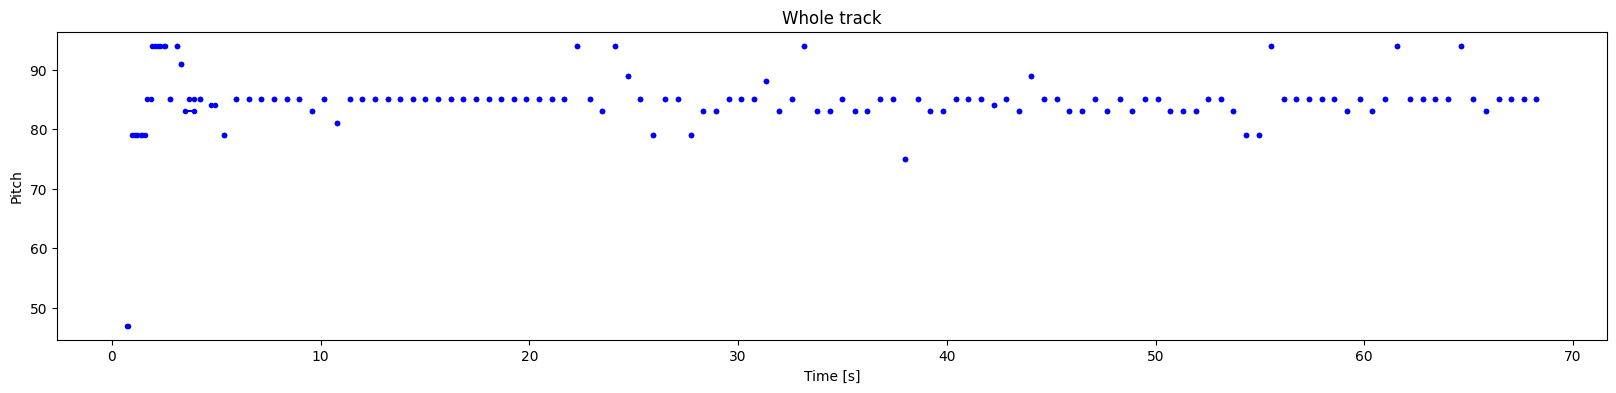

In [66]:
plot_piano_roll(generated_notes)

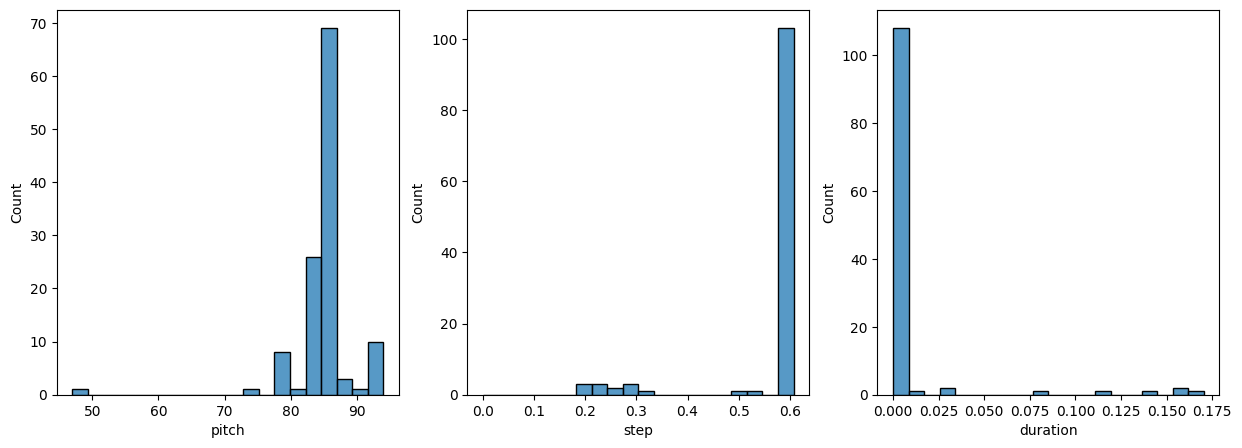

In [67]:
plot_distributions(generated_notes)

In [68]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-04-08 16:05:54.959937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.960011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.960028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.960208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.960222: I tensorflow/core/common_runtime/gpu/gpu

True

In [69]:
from tensorflow.python.client import device_lib

In [70]:
print(device_lib.list_local_devices() )       # GPU 나와야함
print(tf.config.list_physical_devices('GPU')) # 목록 나와야함

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9584099607631497575
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14211350528
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1360741839431612674
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-08 16:05:54.969215: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.969264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.969277: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.969473: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 16:05:54.969487: I tensorflow/core/common_runtime/gpu/gpu